In [2]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 불필요한 경고를 무시합니다 (사이파이 이슈 #5998 참조)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 4.1 선형 회귀

- 가장 간단한 모델 중 하나
- 입력 특성의 가중치 합과 편향을 더해 예측을 만듦
- 훈련 방법: RMSE가 최소화되는 방향으로 가중치를 찾음

<img src="https://blog.kakaocdn.net/dn/sWVP6/btqWU8bfHHY/kGo1TPJH2KZSgWK3lht1rk/img.png" width="40%">

## 4.1.1 정규방정식
정규방정식은 비용 함수를 최소화 하는 θ값을 찾기 위한 해석적인 방법이다. 

In [1]:
import numpy as np

X = 2*np.random.rand(100, 1)               # rand(m, n): 0~1의 균일분포 표준정규분포 난수를 array(m, n) 생성
y = 4 + 3*X + np.random.randn(100, 1)      # randn(m, n): 평균 0, 표준편차 1의 가우시안 표준정규분포 난수를 array(m, n) 생성

그림 저장: generated_data_plot


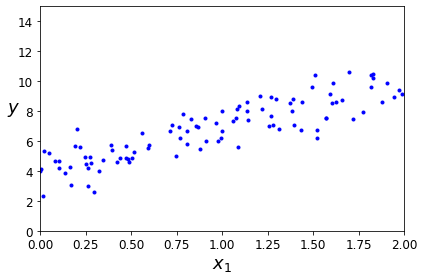

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

정규방정식을 사용하여 θ를 계산해보자.  
inv()함수를 사용해 역행렬을 계산하고 dot()을 사용해 행렬 곱셈을 한다. 아래의 그림과 똑같은 식을 만드는 것이다.

<img src="https://blog.kakaocdn.net/dn/GbrtN/btqW1tLVqHk/DgvxA4d7F9FQ8tRIcqB9vK/img.jpg" width="40%">

In [4]:
X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0 = 1을 추가함. 벡터형식으로 나타낼 때 x0은 항상 1로 나타냄.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[3.98491357],
       [2.95271777]])

우리가 만든 식은 "y = 4 + 3*X + 가우시안 잡음"이기 때문에 $θ_0=4$와 $θ_1=3$을 기대했다.  
하지만 _가우시안 잡음_ 으로 인해 3.9와 2.9가 나왔다.  
우리가 구한 $θ$를 사용하여 그래프를 그려보자.

In [5]:
X_new = np.array([[0], [2]])    # 점 두개로 일단 그래프 그려~!~!
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0 = 1을 추가합니다.
y_predict = X_new_b.dot(theta_best)    # 우리가 구한게 theta_best
y_predict

array([[3.98491357],
       [9.89034912]])

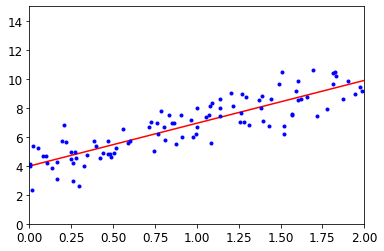

In [6]:
plt.plot(X_new, y_predict, "r-")    # 그래프 그리는 식
plt.plot(X, y, "b.")                # 점 찍는 식
plt.axis([0, 2, 0, 15])
plt.show()

이번에는 사이킷런으로 선형 회귀를 수행해보자.

In [7]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.98491357]), array([[2.95271777]]))

In [8]:
lin_reg.predict(X_new)

array([[3.98491357],
       [9.89034912]])

값이 모두 일치한다. 정규방정식으로 구한 것과 선형 회귀로 구한게 같게 나온다.  
LinearRegression 클래스는 scipy.linalg.lstsq() 함수("least squares"의 약자)를 사용하므로 이 함수를 직접 사용할 수 있다:

In [9]:
# 최소 제곱
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.98491357],
       [2.95271777]])

이 함수는 $\mathbf{X}^+\mathbf{y}$을 계산합니다. $\mathbf{X}^{+}$는 $\mathbf{X}$의 유사역행렬 (pseudoinverse)입니다(Moore–Penrose 유사역행렬입니다). np.linalg.pinv()을 사용해서 유사역행렬을 직접 계산할 수 있습니다:

$\boldsymbol{\hat{\theta}} = \mathbf{X}^{-1}\hat{y}$

In [10]:
# 유사역행렬
np.linalg.pinv(X_b).dot(y)

array([[3.98491357],
       [2.95271777]])

# 4.2 경사 하강법
## 4.2.1 배치 경사 하강법 

In [11]:
eta = 0.1  # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # 랜덤 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)    # 경사 하강법의 스탭 그 자체
    theta = theta - eta * gradients

In [12]:
# 구해진 세타값
theta

array([[3.98491357],
       [2.95271777]])

In [13]:
# 예측값
X_new_b.dot(theta)

array([[3.98491357],
       [9.89034912]])

학습률이 달라지면 어떻게 달라질까?

In [14]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

그림 저장: gradient_descent_plot


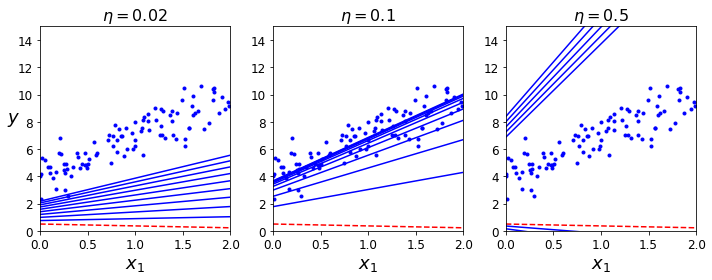

In [15]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)    # 학습률 작게
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)    # 학습률 기본
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)    # 학습률 높게

save_fig("gradient_descent_plot")
plt.show()

## 4.2.2 확률적 경사 하강법

In [16]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

그림 저장: sgd_plot


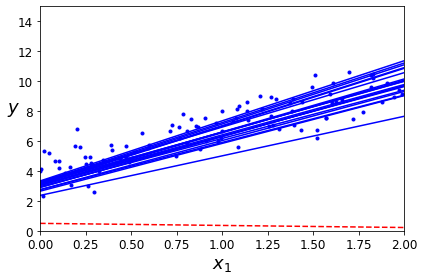

In [17]:
n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):  # 학습 스케줄: 매 반복에서 학습률을 결정하는 함수
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # 랜덤 초기화

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("sgd_plot")
plt.show() 

SGD 방식으로 선형회귀를 사용하자.  
에포크: 최대 1000회  
손실: 0.001보다 적게 줄어들 때까지  
학습률: 0.01

In [18]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [19]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.91926289]), array([2.87645857]))

## 4.2.3 미니배치 경사 하강법

In [20]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [21]:
theta_path_bgd = np.array(theta_path_bgd)  # 배치
theta_path_sgd = np.array(theta_path_sgd)  # 확률적
theta_path_mgd = np.array(theta_path_mgd)  # 미니배치

그림 저장: gradient_descent_paths_plot


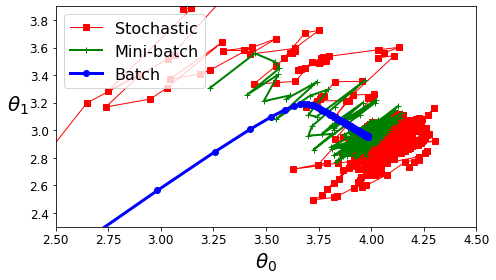

In [22]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")  # 확률적
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")  # 미니배치
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")       # 배치
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

파란색(배치)은 실제로 최솟값에서 멈춤﻿ → 매 스텝에서 많은 시간 소요  
빨간색(확률적), 초록색(미니배치)는 최솟값에서 맴돎 → 적절한 학습 스케줄로 최솟값 도달 도와야 함